## libraries

In [ ]:
import numpy as np
import os
import cv2
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import keras
import tensorflow as tf
import keras.backend as K
from collections import Counter
from tensorflow.python.client import device_lib
from keras.optimizers import Adam, Adamax, SGD
import imutils
import tensorflow_addons as tfa
from keras.models import load_model

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)
tf.keras.backend.clear_session()
TF_ENABLE_ONEDNN_OPTS=0
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(tf.device('/gpu:0'))

tf.device('/gpu:0')

In [ ]:
base_path="/home/neel/Acoustic/Acoustics/dataset"
audio_path=os.path.sep.join([base_path,"datachunks"])
annots_path=os.path.sep.join([base_path,"train.csv"])

base_output="/home/neel/Acoustic/Acoustics/output3.0"
test_file=os.path.sep.join([base_output,"test.txt"])

## Generate Spectrograms and labels

In [ ]:
print("[INFO] loading dataset...")
rows = open(annots_path).read().strip().split("\n")
spectrogram=np.empty(((len(rows)),257,273,2), dtype="float32")
bounding_box_cords=[]
window_size=int(512)
wd = signal.windows.hamming(window_size)
slide_size = int(4)
overlap = window_size - slide_size
filenames=[]
cnt=0
for row in rows:
    # print(cnt)
    row = row.split(",")
    (filename1,filename2,X, Y, W, H) = row
    channel1_Path = os.path.sep.join([audio_path, filename1])
    channel2_path = os.path.sep.join([audio_path, filename2])
    
    channel1,sample_rate=librosa.load(channel1_Path,sr=None)
    channel2,sample_rate=librosa.load(channel2_path,sr=None)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')

    # print(image1.shape)
    data=np.stack((spectrum1,spectrum2),axis=-1)
    spectrogram[cnt]=data
    del data,frequency,time
    cnt+=1
    bounding_box_cords.append((X, Y, W, H))
    filenames.append([filename1,filename2])
    # filenames.append(filename1)
print("Done.")

## Normalize spectrogram

In [ ]:
print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))
for i in range(8831):
    min=spectrogram[i].min()
    max=spectrogram[i].max()
    spectrogram[i]= (spectrogram[i]-min)/(max-min)


print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))

In [ ]:
del channel1,channel2,rows,spectrum1,spectrum2


In [ ]:
targets = np.array(bounding_box_cords, dtype="float32")
print(targets.shape)
print(spectrogram.shape)

## Train - Validation split

In [ ]:
split = train_test_split(spectrogram, targets, filenames, test_size=0.10,random_state=42)
del spectrogram, targets, filenames
(trainData, testData) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
del split

print("[INFO] saving testing filenames...")
f = open(test_file, "w")
for i in testFilenames:
    f.write(i[0]+","+i[1])
    f.write("\n")
# f.write("\n".join(testFilenames))
f.close()

print("Training examples: ",trainData.shape)
print("Testing examples: ",testData.shape)

## Model Building

#### VGG

In [ ]:
def vgg():
    model = tf.keras.Sequential()
    # Block 1
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv1", input_shape=(257,273,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block1_pool'))

    # Block 2
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv1"))
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block2_pool'))

    # Block 3
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv1"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv2"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block3_pool'))

    # Block 4
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block4_pool'))

    # Block 5
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block5_pool'))

    # FC 
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_1'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_2'))
    model.add(tf.keras.layers.Dense(1024, activation='relu', name='fc_3'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_3'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_4'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_4'))

    # Output
    model.add(tf.keras.layers.Dense(4, activation='relu', name='output'))

    model.summary()
    return model
model=vgg()
model.summary()


#### ANN

In [ ]:
def ANN():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(140322,)))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))

    return model
model=ANN()
model.summary()

#### 1cnn to dense

In [ ]:
def cnn_dense():
    model= tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2, input_shape=(257,273,2), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid', strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4,activation='sigmoid'))
    
    return model

cnn_dense().summary()

### Loss Function

In [ ]:

def l2_loss_func(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true))


def iou_loss_func(y_true, y_pred):
  # Convert the predicted and ground truth bounding boxes to a format
  # suitable for calculating the IOU
  y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

  # Calculate the IOU between the predicted and ground truth bounding boxes
  x1_true, y1_true, x2_true, y2_true = tf.split(y_true, 4, axis=-1)
  x1_pred, y1_pred, x2_pred, y2_pred = tf.split(y_pred, 4, axis=-1)
  x1_true, x2_true, x1_pred, x2_pred= x1_true*1440 , x2_true*1440, x1_pred*1440, x2_pred*1440
  y1_true, y2_true, y1_pred, y2_pred= y1_true*1080 , y2_true*1080, y1_pred*1080, y2_pred*1080
  area_true = (x2_true - x1_true + 1) * (y2_true - y1_true + 1)
  area_pred = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)
  x1_true = K.maximum(x1_true, x1_pred)
  y1_true = K.maximum(y1_true, y1_pred)
  x2_true = K.minimum(x2_true, x2_pred)
  y2_true = K.minimum(y2_true, y2_pred)
  intersection = K.maximum(0.0, x2_true - x1_true + 1) * K.maximum(0.0, y2_true - y1_true + 1)
 
  iou = intersection / (area_true + area_pred - intersection)
  return 1-iou

def combined_loss(y_true, y_pred):
  # Calculate the Smooth L1 loss and IOU loss
  l2_loss = l2_loss_func(y_true, y_pred)
  iou_loss = iou_loss_func(y_true, y_pred)

  # Combine the losses with a weight
  loss = 0.3 * l2_loss + 0.7 * iou_loss
  return loss

### Hyps

In [ ]:
init_lr=1e-4
epoch=120
batch_size=32
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=20,
    decay_rate=0.1,
    staircase=True)
opt = SGD(learning_rate=lr_schedule ,momentum=0.9)


### Model Run

#### VGG 

In [ ]:
model=vgg()
model.compile(optimizer=opt, loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		validation_data=(testData, testTargets),
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/vgg.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/vgg.png")

#### ANN

In [ ]:
trainData1=trainData.reshape(trainData.shape[0],-1)


In [ ]:
model=ANN()
model.compile(optimizer='adam', loss=tfa.losses.GIoULoss(), metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData1, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)


In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/ann.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/ann.png")

#### CNN DENSE

In [ ]:
model=cnn_dense()
model.compile(optimizer='adam', loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/cnn_dense_new.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.title("L2 + IoU loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(base_output+"/cnn_dense_new.png")

## Testing

In [26]:
model=load_model(base_output+"/cnn_dense_new.h5", compile=False)
for i,img in enumerate(trainFilenames):
    if i==20:
        break
    audioPath1=os.path.sep.join([audio_path, img[0]])
    audioPath2=os.path.sep.join([audio_path, img[1]])
    channel1,sample_rate=librosa.load(audioPath1,sr=None)
    channel2,sample_rate=librosa.load(audioPath2,sr=None)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    spectrum1=np.expand_dims(spectrum1,axis=0)
    spectrum2=np.expand_dims(spectrum2,axis=0)
    spectrogram=np.stack((spectrum1,spectrum2),axis=-1)

    # normalize
    min=spectrogram.min()
    max=spectrogram.max()
    spectrogram= (spectrogram-min)/(max-min)
    preds = model.predict(spectrogram)[0]
    (startX, startY, endX, endY) = preds
    startX,endX=startX*1440, endX*1440
    startY,endY=startY*1080, endY*1080
    width=endX-startX
    height=endY-startY
    f=open("/home/neel/Acoustic/Acoustics/dataset/labels/"+img[0][9:-4]+".txt")
    ground_truth=f.read().replace('\n','').split(" ")
    ground_startX=float(ground_truth[1])
    ground_startY=float(ground_truth[2])
    ground_width=float(ground_truth[3])
    ground_height=float(ground_truth[4])
    ground_startX*=1440
    ground_width*=1440
    ground_startY*=1080
    ground_height*=1080
    print("Image name: ",img[0])
    print("Ground truth: ",ground_startX,ground_startY,ground_width,ground_height)
    print("Predicted: ",startX, startY, width, height)

1/1 [==============================] - 0s 229ms/step
Image name:  channel1_4m_train41_13.wav
Ground truth:  93.50006400000001 533.0005199999999 137.000016 64.000044
Predicted:  8.501063659787178 446.8423640727997 146.53761260211468 156.54033780097961
1/1 [==============================] - 0s 29ms/step
Image name:  channel1_4m_train28_22.wav
Ground truth:  169.49952 402.99984 153.0 68.00004
Predicted:  3.0831479653716087 471.11778259277344 118.67167476564646 173.01722288131714
1/1 [==============================] - 0s 28ms/step
Image name:  channel1_3m_train33_28.wav
Ground truth:  1063.5004800000002 534.9996 184.99968 100.000008
Predicted:  825.2681636810303 486.8568241596222 327.76988983154297 100.75751423835754
1/1 [==============================] - 0s 23ms/step
Image name:  channel1_3m_train13_28.wav
Ground truth:  1043.50032 314.50032000000004 175.00032 100.99998000000001
Predicted:  763.7530517578125 285.9153914451599 200.70570945739746 132.99214124679565
1/1 [====================

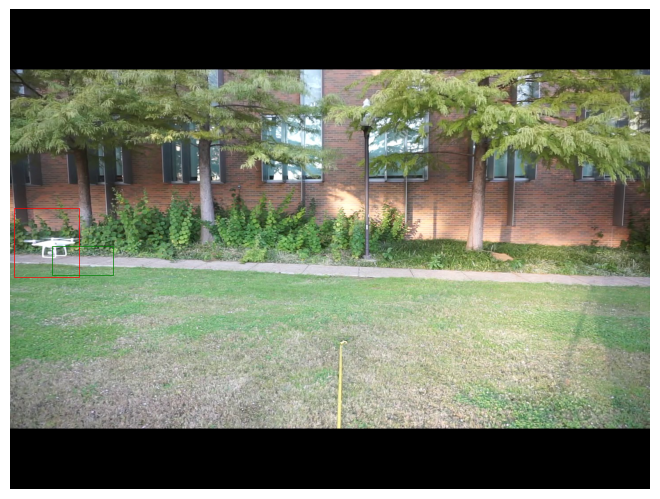

In [27]:
from matplotlib import patches
import matplotlib.pyplot as plt
import cv2

startX,startY, width, height=8.501063659787178 ,446.8423640727997, 146.53761260211468 ,156.54033780097961
X,Y,W,H=93.50006400000001 ,533.0005199999999, 137.000016, 64.000044

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/4m_train41_13.jpg')
plt.imshow(image)
plt.axis('off')
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((X,Y),W,H, edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)

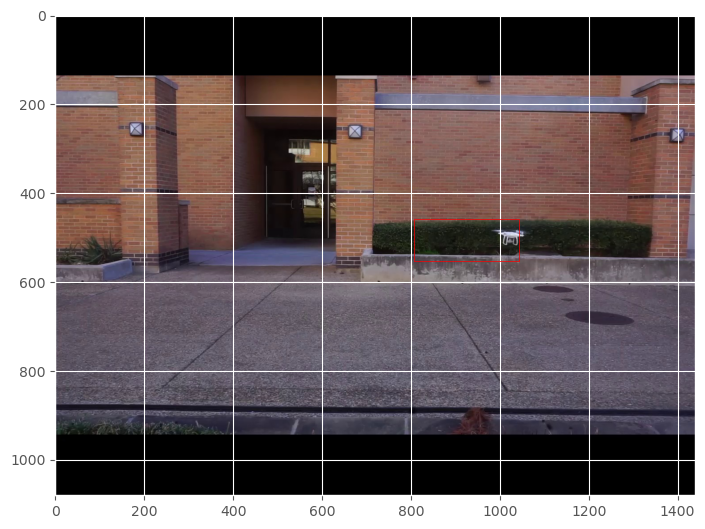

In [28]:
startX,startY, width, height= 806.4463520050049, 457.29995369911194, 236.2412452697754, 94.44168448448181
# X,Y,W,H=1024.49952, 498.99996 ,83.000016, 50.000004
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/normal_train119_26.jpg')
plt.imshow(image)
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
# rect2 = patches.Rectangle((X,Y),W,H, edgecolor='g', facecolor='none')
ax.add_patch(rect)
# ax.add_patch(rect2)